In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np
%matplotlib inline


# Exploratory Data Analysis

The main question I seek to explore in this project, is whether playing the computer-game *Counter Strike: Global Offensive* (CSGO) in the evening has an effect on the quality of my sleep. 

*But why assume that gaming has an effect?*

Because screen time during the evening exposes you to blue-light and according to sleep-experts - such as Matthew Walker, researcher and author of: *Why We Sleep* - this impacts over sleep cycle. Additionally, CSGO is a highly intensive game where the question of doing well depends on quick reflexes. These two factors was reason enough for me to investigate whether there are any correlation between 
nightly gaming sessions and sleeping quality. Therefore I decided to stop playing computer games from the **2020-09-01** and going forward, to see if any significant change in sleep quality could be detected in my fitbit data. However, just as I stopped playing the weather conditions in Denmark started spiking and I recall having trouble falling asleep due to the heat, and thus I decided to also include weather-data from the Danish Meteological Institute (DMI) into the project.


**Data Sources:**
* Personal Fitbit Data
    * Sleep Data
    * Activity Data
* DMI weather data

**Challenges:**

The data is from the period **2020-05-02 - 2020-10-14** and whether there is a data point varies for each data source. This is mainly due to the fact that the fitbit data I downloaded has varying degrees of quality. For example, the physical data (periods of high heart rate and etc.), was packaged into both .JSON .csv and .txt files and the sheer amount of cleaning necessary to be done would be a big task. Therefore I gathered the data from a different part of the fitbit webpage, where it was possible to get the data as daily entries into a .csv file, however this was only possible to do for September and Oktober.


## 1. Data Wrangling


### 1.1 Read in Sleep Data

In [2]:
# Read in sleep data
df = pd.read_csv('data/MyFitbitData/AndreasHald/Sleep/sleep_score.csv')
# print(df.dtypes)
# df.head()

In [3]:
df['ymd'] = pd.to_datetime(df['timestamp']).dt.date
# df.head()

### 1.2 Read in Fitbit Physical Data

In [4]:
os.chdir('data/MyFitbitData/AndreasHald/Physical Activity/')

In [5]:
df_september = pd.read_csv('fitbit_export_september.csv', skiprows=1) # Skip column names
df_oktober = pd.read_csv('fitbit_export_oktober.csv', skiprows=1)

In [6]:
# df_activity = pd.concat([df_september, df_oktober]) # Join dataframes

In [7]:
df_activity = df_september.append(df_oktober)

In [8]:
df_activity['ymd'] = pd.to_datetime(df_activity['Date'], format='%d-%m-%Y').dt.date # Change to ymd (year month day)-order
df_activity.dtypes

Date                       object
Calories Burned            object
Steps                      object
Distance                  float64
Floors                      int64
Minutes Sedentary          object
Minutes Lightly Active      int64
Minutes Fairly Active       int64
Minutes Very Active         int64
Activity Calories          object
ymd                        object
dtype: object

### 1.3 Read in DMI Weather data

In [9]:
import os

os.chdir('../../../WeatherData/Copenhagen/')

# os.chdir('data/WeatherData/Copenhagen/')

df_w = None

# Read in all the .csv files: 
for i, file in enumerate(os.listdir()):
    if i == 0:
        df_w = pd.read_csv(file, delimiter=';')
    else:
        df_tmp = pd.read_csv(file, delimiter=';')
        df_w = pd.concat([df_w, df_tmp])
        
df_w.sort_values('DateTime',inplace=True)

In [10]:
df_w['ymd'] = pd.to_datetime(df_w['DateTime']).dt.date
df_w.head()

,DateTime,Laveste,Højeste,Middel,ymd
0,2020-01-01 00:00:00,0.8,6.0,4.0,2020-01-01
1,2020-01-02 00:00:00,0.9,3.1,1.9,2020-01-02
2,2020-01-03 00:00:00,2.2,7.3,5.1,2020-01-03
3,2020-01-04 00:00:00,0.3,6.0,4.1,2020-01-04
4,2020-01-05 00:00:00,-1.7,5.8,2.6,2020-01-05


### 1.4 Merge all Data

In [11]:
df_master = pd.merge(df, df_w, on='ymd', how='left')
df_master = pd.merge(df_master, df_activity, on='ymd', how='left')

df_master.shape

(152, 24)

In [12]:
print(df.shape)
print(df_w.shape)
print(df_activity.shape)
print(df_master.shape)

(152, 10)
(305, 5)
(50, 11)
(152, 24)


### 2: Explore

In [13]:
# Select specific relevant columns
df_using = df_master[['ymd', 
           'overall_score', 
           'deep_sleep_in_minutes', 
           'restlessness', 
#            'Laveste', 
#            'Middel', 
           'Højeste', 
           'Calories Burned', 
           'Steps',
           'Distance',
           'Minutes Sedentary',
           'Minutes Fairly Active',
           'Minutes Very Active',
          ]]

In [14]:
# Define 
stop_date = datetime.datetime.strptime('2020-09-01', '%Y-%m-%d').date()

In [15]:
df_using['game_night'] = df_using['ymd'] < stop_date

<ipython-input-15-c762fe6c2ac5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_using['game_night'] = df_using['ymd'] < stop_date


<AxesSubplot:>

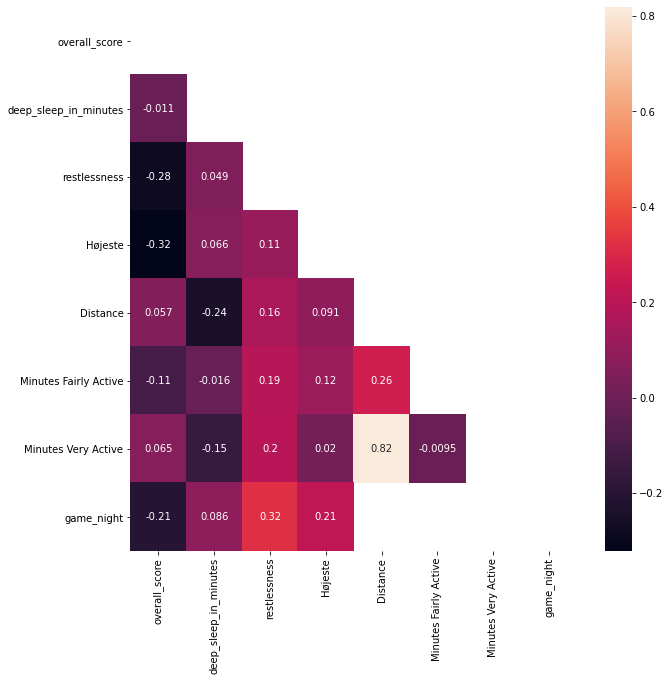

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
mask = np.zeros_like(df_using.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_using.corr(),annot=True, mask=mask)


#### Investigating Linear Correlation:

The heatmap above, shows no remarkable correlation interaction between the 3 datasets. While Distance and Minutes Very Active has a high positive correlation, this is expected, because the the longer I am active, the further I tend to travel in distance, and these are typically days that I go for a run and/or walk.

Nevertheless, there are some weak negative correlation between the columns "restlesness", "højeste", "game_night" and "overall_score". Further there seems to be a weak positive correlation between "game_night" and "restlessness".

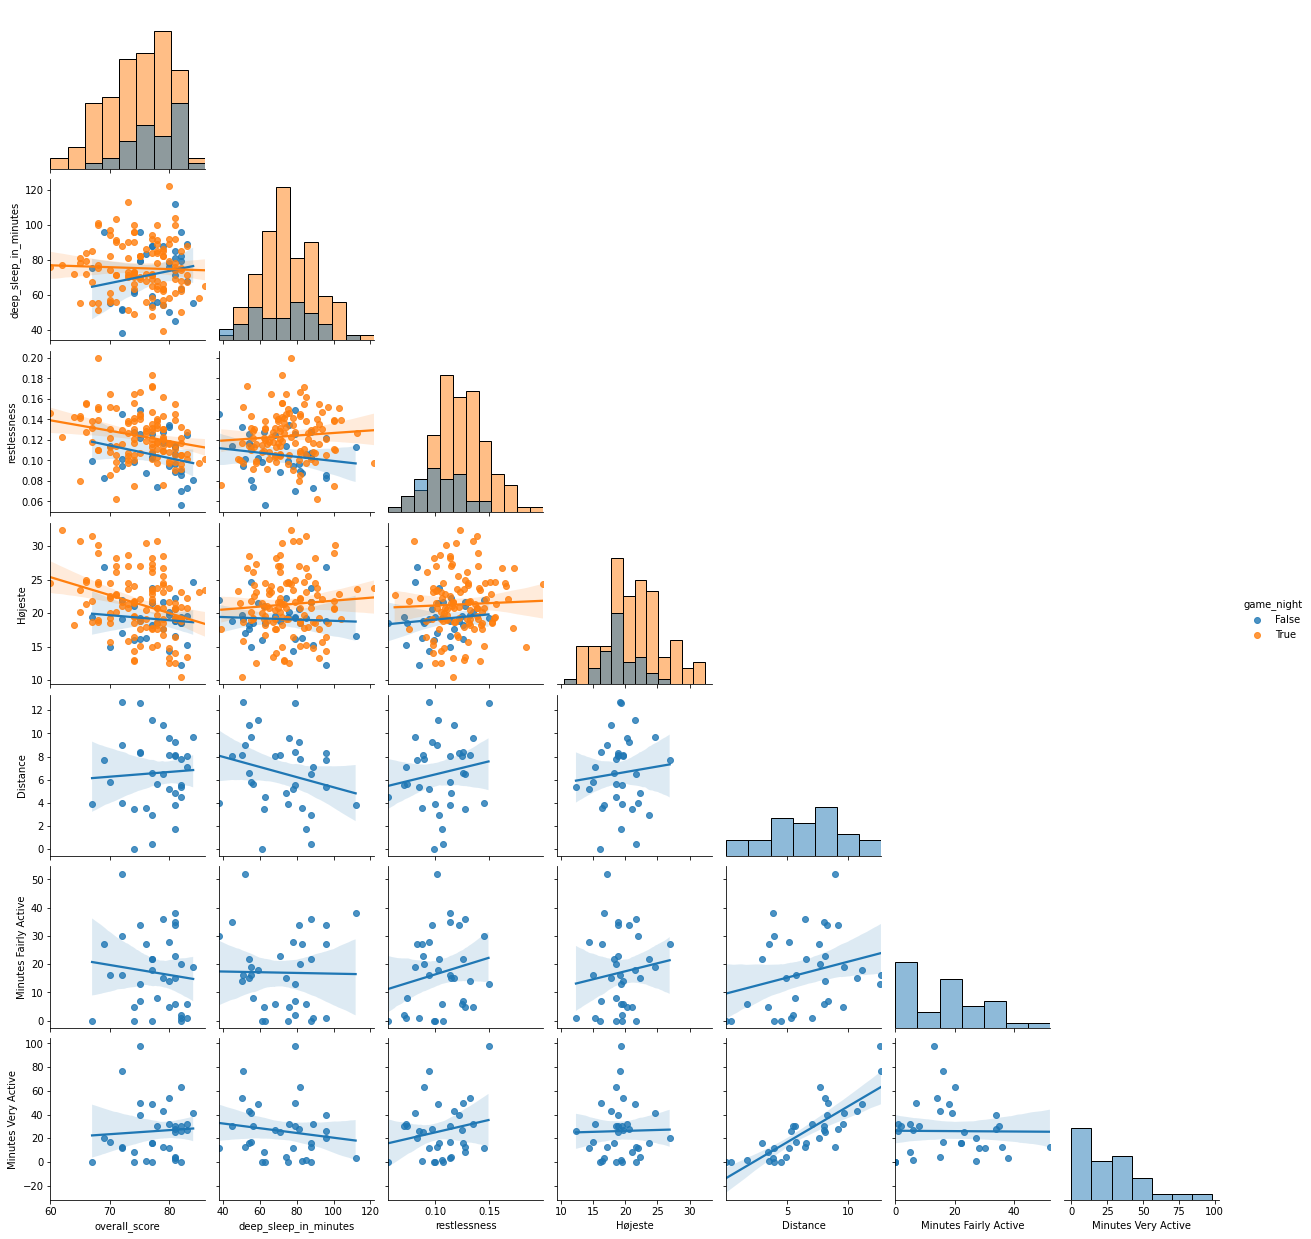

In [17]:
sns.pairplot(df_using,
             hue='game_night',
             diag_kind='hist',
             kind='reg',
             corner=True)

The correlations mentioned above, are arguably harder to spot on the preceding pairplot, partly because variance is high for most of the paired scatter plots and it is obvious that any linear regression model plotted over these variables would suffer from heteroscedasticity. 

One approach could be to try and remove extreme outliers from the variables and then try to reinvestigate the correlations. However, instead I want to briefly consider the 'overall_score'-variable and the general dynamics of my sleep pattern.

Generally, I have a pretty stable routine: to bed between 22:00-23:00, wake up at 6:30-7:30. But, I currently live in an apartment complex with rather noisy neighbours. However, their noise-patterns almost varies as much as the datapoints in the scatterlpot underneath and as such I suspect this add considerable noise to the data and as I have not kept track of when this occured, it is hard to account for in the data. 

<AxesSubplot:xlabel='ymd', ylabel='overall_score'>

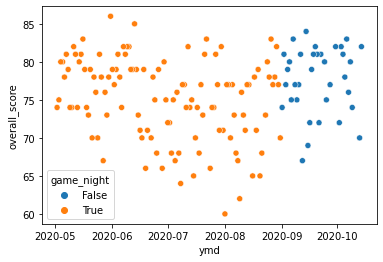

In [18]:
sns.scatterplot(x='ymd', y='overall_score', hue='game_night', data=df_using)

To counter this noise, I will instead convert the 'overall_score'-variable into a rolling average, and see if any larger pattern is more descernible in the data as a result:

In [19]:
# Sort values
df_using.sort_values(by='ymd', inplace=True)
df_using

<ipython-input-19-78362db01d59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_using.sort_values(by='ymd', inplace=True)


,ymd,overall_score,deep_sleep_in_minutes,restlessness,Højeste,Calories Burned,Steps,Distance,Minutes Sedentary,Minutes Fairly Active,Minutes Very Active,game_night
151,2020-05-02,74,73,0.141386,12.9,NaN,NaN,NaN,NaN,NaN,NaN,True
150,2020-05-03,75,82,0.145015,15.1,NaN,NaN,NaN,NaN,NaN,NaN,True
149,2020-05-04,80,89,0.108136,14.8,NaN,NaN,NaN,NaN,NaN,NaN,True
148,2020-05-05,80,58,0.099442,12.6,NaN,NaN,NaN,NaN,NaN,NaN,True
147,2020-05-06,78,85,0.097707,15.3,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-10-07,76,83,0.087302,16.3,"2,551","4,591",3.56,755,27.0,1.0,False
3,2020-10-08,80,78,0.094228,14.3,"2,834","6,692",5.19,621,28.0,12.0,False
2,2020-10-09,74,61,0.098811,16.0,"1,896",53,0.04,890,0.0,0.0,False
1,2020-10-13,70,55,0.113706,15.0,"2,848","7,437",5.77,690,16.0,17.0,False


In [20]:
# Try rolling average
df_using['Højeste_rollavg'] = df_using['Højeste'].rolling(window=7).mean()
df_using['overall_score_rollavg'] = df_using['overall_score'].rolling(window=7).mean()
df_using['restlessness_rollavg'] = df_using['restlessness'].rolling(window=7).mean()

<ipython-input-20-a64797ea21a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_using['Højeste_rollavg'] = df_using['Højeste'].rolling(window=7).mean()
<ipython-input-20-a64797ea21a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_using['overall_score_rollavg'] = df_using['overall_score'].rolling(window=7).mean()
<ipython-input-20-a64797ea21a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<AxesSubplot:xlabel='ymd', ylabel='Højeste'>

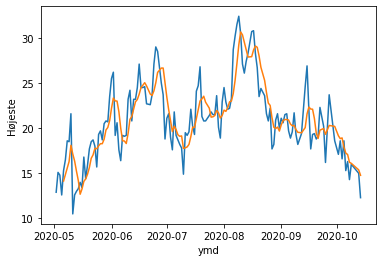

In [21]:
sns.lineplot(x=df_using['ymd'], y=df_using['Højeste'])
sns.lineplot(x=df_using['ymd'], y=df_using['Højeste'].rolling(window=5).mean())

In [22]:
# Try normalizing dataframe

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

In [24]:
df_using[['overall_score', 
          'overall_score_rollavg',
          'Højeste_rollavg']] = minmax_scale(df_using[['overall_score', 'overall_score_rollavg','Højeste_rollavg']])

<ipython-input-24-3965d8d9ccdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_using[['overall_score',
/home/andreas/.virtualenv/statistics/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


<AxesSubplot:xlabel='ymd', ylabel='overall_score_rollavg'>

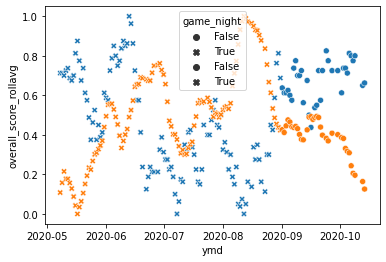

In [25]:
sns.scatterplot(x='ymd', y='overall_score_rollavg', data=df_using, style='game_night')
sns.scatterplot(x='ymd', y='Højeste_rollavg', data=df_using, style='game_night')

<AxesSubplot:>

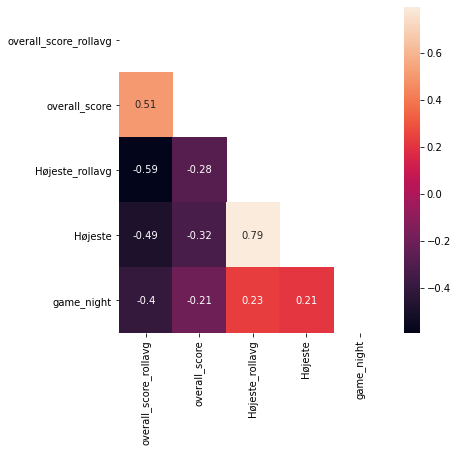

In [26]:
# df_tmp = df_using.loc[df_using['game_night'] == False]
df_tmp = df_using[['ymd','overall_score_rollavg', 'overall_score','Højeste_rollavg', 'Højeste', 'game_night']]


fig, ax = plt.subplots(figsize=(6,6))
mask = np.zeros_like(df_tmp.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_tmp.corr(),annot=True, mask=mask)


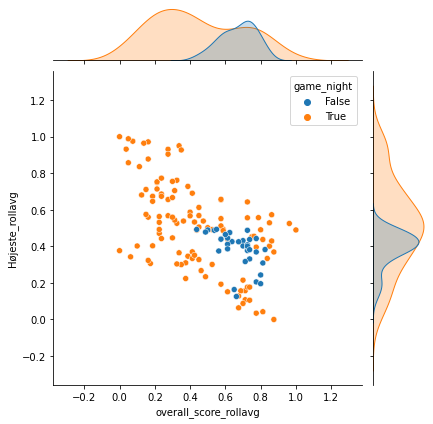

In [27]:
sns.jointplot(x='overall_score_rollavg', y='Højeste_rollavg', data=df_using, hue="game_night")

In [28]:
df_tmp.reset_index(inplace=True)


In [29]:
df_tmp.drop('index', axis=1, inplace=True)

/home/andreas/.virtualenv/statistics/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
df_tmp.reset_index(inplace=True)

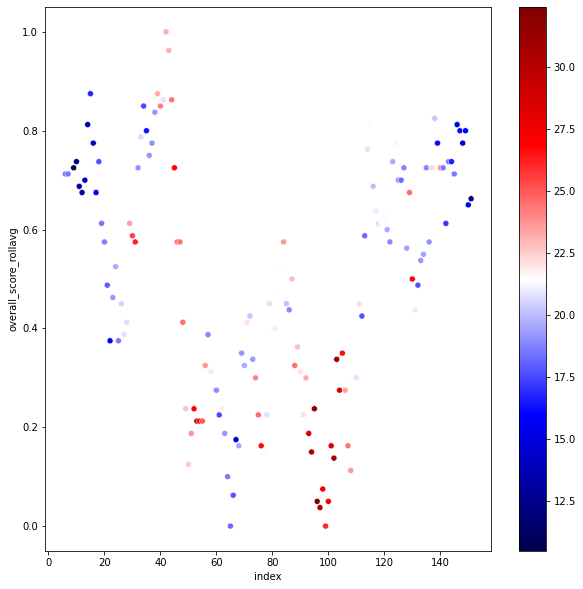

In [41]:
# sns.set()
fig, ax = plt.subplots(figsize=(10,10))

cmap='seismic'

ax = sns.scatterplot(x='index', 
           y='overall_score_rollavg', 
           hue='Højeste', 
           palette=cmap,
           data=df_tmp)


norm = plt.Normalize(df_tmp['Højeste'].min(), df_tmp['Højeste'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax.legend().remove()
ax.figure.colorbar(sm)

plt.show()

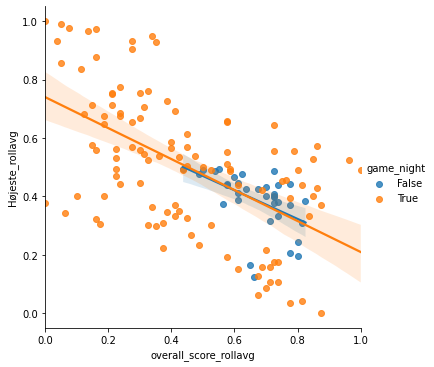

In [32]:
# df_tmp.reset_index(inplace=True)
sns.lmplot(x='overall_score_rollavg', y='Højeste_rollavg', hue='game_night', data=df_tmp)